# **Deep Learning Model**
Neste notebook tem os seguintes modelos de aprendizado de profundo comparados:
- LSTM

## **Prepare Environment**

<br/>

### Imports

In [13]:
# Data analysis and data wrangling
import numpy as np
import pandas as pd

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# deep learning
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Other
from IPython.display import Image
from time import time
import configparser
import subprocess
import warnings
import pprint
import os

<br/>

### Prepare Principal Directory

In [14]:
def path_to_work(end_directory: str='notebooks'):
    curr_dir = os.path.dirname(os.path.realpath ("__file__")) 
    
    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return f'Change directory to: {curr_dir}'
    
    return f'Current working directory: {curr_dir}'

In [15]:
path_to_work('notebooks')

'Change directory to: /home/campos/projects/tcc-ufsc-grad/notebooks'

<br/>

### Set Config

In [16]:
# Visualization inside the jupyter
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500, 
    'figure.autolayout': True, 
    'figure.figsize': [17, 12], 
    'axes.labelsize': 18,
    'axes.titlesize': 18, 
    'font.size': 10, 
    'lines.linewidth': 1.0, 
    'lines.markersize': 8, 
    'legend.fontsize': 15,
    'xtick.labelsize': 15, 
    'ytick.labelsize': 15}

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True, 
        rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

In [17]:
plt.style.use('seaborn')  # fivethirtyeight
plt.rc('figure',figsize=(16,8))
plt.rc('font',size=15)
plt.rc('legend',fontsize=15)

# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='dark', palette='deep')

plt.style.use('fivethirtyeight')

<br/>

### Load Data

In [18]:
%%time

df_vale3 = pd.read_csv('data/cleansing/df_vale3_cleansing.csv',
                        encoding='utf8',
                        delimiter=',',
                        parse_dates=True,
                        index_col=0,
                        verbose=True)

Tokenization took: 3.50 ms
Type conversion took: 10.41 ms
Parser memory cleanup took: 0.02 ms
CPU times: user 35.2 ms, sys: 0 ns, total: 35.2 ms
Wall time: 33.4 ms


In [19]:
print(df_vale3.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2445 entries, 2010-07-12 to 2020-05-28
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   preco         2445 non-null   float64
 1   residuos      2445 non-null   float64
 2   tendencia     2445 non-null   float64
 3   sazonalidade  2445 non-null   float64
 4   diff_1        2445 non-null   float64
 5   diff_2        2445 non-null   float64
 6   diff_3        2445 non-null   float64
 7   diff_4        2445 non-null   float64
 8   diff_5        2445 non-null   float64
dtypes: float64(9)
memory usage: 191.0 KB
None


In [20]:
df_vale3.head()

,preco,residuos,tendencia,sazonalidade,diff_1,diff_2,diff_3,diff_4,diff_5
data,,,,,,,,,
2010-07-12,40.00,1.00,41.83,1.00,-0.60,-0.46,0.49,0.98,0.42
2010-07-13,40.07,1.04,41.91,1.00,0.07,-0.53,-0.39,0.56,1.05
2010-07-14,40.08,1.03,41.98,1.00,0.01,0.08,-0.52,-0.38,0.57
2010-07-15,39.76,1.04,42.05,1.00,-0.32,-0.31,-0.24,-0.84,-0.70
2010-07-16,38.88,1.03,42.12,1.00,-0.88,-1.20,-1.19,-1.12,-1.72


---

## **Split Data**

In [21]:
size_train = 2132
size_test = 313
print(size_train)
print(size_test)

df_train = df_vale3.iloc[:size_train]
df_test = df_vale3.iloc[size_train:]
print(df_train.columns)
print(df_test.columns)

2132
313
Index(['preco', 'residuos', 'tendencia', 'sazonalidade', 'diff_1', 'diff_2',
       'diff_3', 'diff_4', 'diff_5'],
      dtype='object')
Index(['preco', 'residuos', 'tendencia', 'sazonalidade', 'diff_1', 'diff_2',
       'diff_3', 'diff_4', 'diff_5'],
      dtype='object')


Text(0.5, 1.0, 'Train size: 2132')

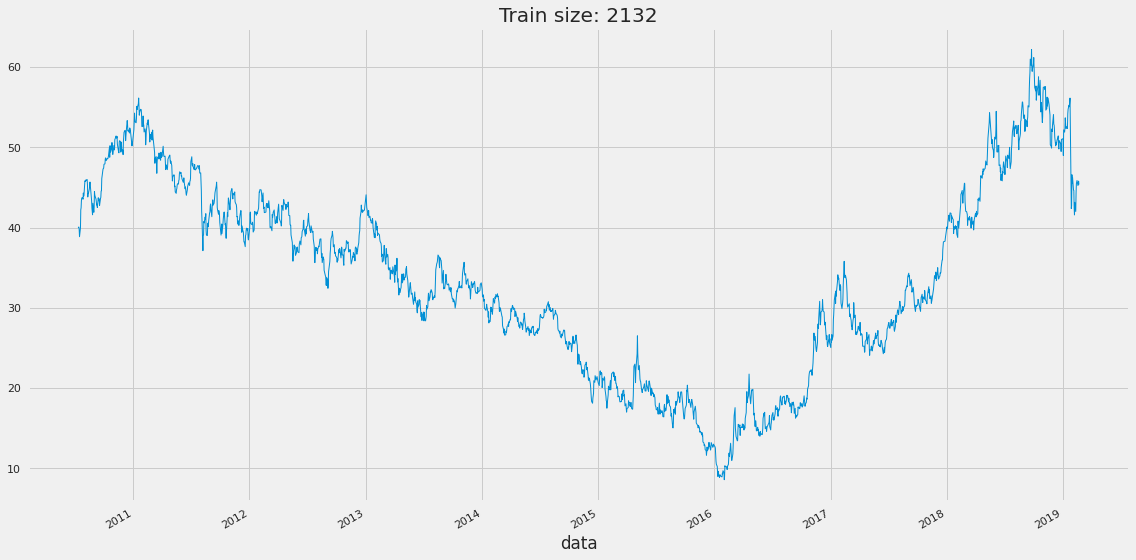

In [22]:
df_train['preco'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Train size: {len(df_train)}')

Text(0.5, 1.0, 'Test size: 313')

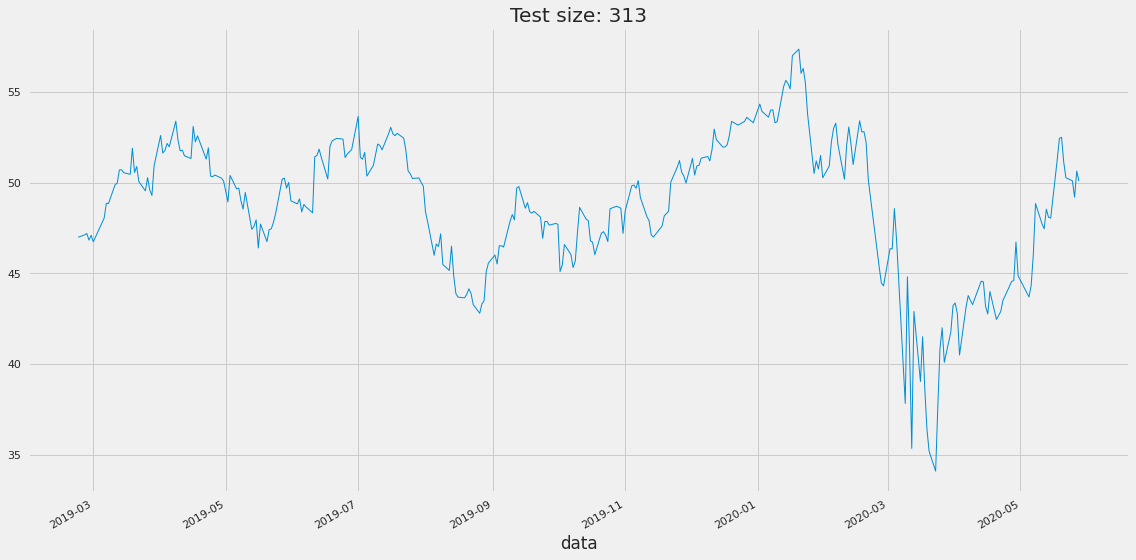

In [23]:
df_test['preco'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Test size: {len(df_test)}')

In [24]:
df_train.index

DatetimeIndex(['2010-07-12', '2010-07-13', '2010-07-14', '2010-07-15',
               '2010-07-16', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23',
               ...
               '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21'],
              dtype='datetime64[ns]', name='data', length=2132, freq=None)

In [25]:
df_test.index

DatetimeIndex(['2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27',
               '2019-02-28', '2019-03-01', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11',
               ...
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-25', '2020-05-26',
               '2020-05-27', '2020-05-28'],
              dtype='datetime64[ns]', name='data', length=313, freq=None)

---

## **Evaluation**

In [26]:
dict_results = {}

<br/>

### Display Results

In [27]:
def show_result_model(df_train, df_test, y_forecast, model_name):
    future_forecast = pd.DataFrame(y_forecast,
                                   index=df_test.index,
                                   columns=['previsao'])
    #mape = mean_absolute_percentage_error(df_test, y_forecast)
    mape = mean_absolute_percentage_error(df_test, y_forecast)*100
    
    mse = mean_squared_error(df_test, y_forecast, squared=True)
    dict_results[model_name] = [mape, mse]
    
    pd.concat([df_test, future_forecast], axis=1).plot()

    plt.legend()
    plt.grid(True)
    plt.xlabel("Tempo (dias)", fontsize=20)
    plt.ylabel("Preço (R$)", fontsize=20)
    plt.title(f'MAPE = {mape:.2f} % | MSE = {mse:.2f}', fontsize=25)

---

## **Modeling**

### Normalização dos Dados

In [28]:
train_max = df_train.max()
train_min = df_train.min()

train = (df_train - train_min)/(train_max - train_min)
test = (df_test - train_min)/(train_max - train_min)

In [29]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    
    return np.array(Xs).astype('float32'), np.array(ys).astype('float32')

In [30]:
time_steps = 1

X_train, y_train = create_dataset(train, train['preco'], time_steps)
X_test, y_test = create_dataset(test, test['preco'], time_steps)

<br/>

### **Build Model**

#### LSTM
- reference: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [31]:
# sequential model
model_lstm = Sequential(name='lstm_vale3')
model_lstm

2021-12-21 21:43:45.645420: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-21 21:43:45.645522: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (avell): /proc/driver/nvidia/version does not exist
2021-12-21 21:43:45.646523: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Input Layer

In [32]:
#Adding the first LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=len(df_train.columns),
                    return_sequences=True,
                    input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))

#### Hidden Layers

In [33]:
# Adding a second LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=10, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=10, return_sequences=True))
model_lstm.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model_lstm.add(LSTM(units=10))
model_lstm.add(Dropout(0.2))

#### Output Layer

In [34]:
model_lstm.add(Dense(units=1))

### Compilação da RNA

In [35]:
model_lstm.compile(loss='mean_squared_error',
                   optimizer='adam',
                   metrics=['mse', 'mape'])

### Resumo da RNA

In [36]:
model_lstm.summary()

Model: "lstm_vale3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 9)              684       
                                                                 
 dropout (Dropout)           (None, 1, 9)              0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 10)             800       
                                                                 
 dropout_1 (Dropout)         (None, 1, 10)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 10)             840       
                                                                 
 dropout_2 (Dropout)         (None, 1, 10)             0         
                                                                 
 lstm_3 (LSTM)               (None, 10)                8

<br/>

### **Training**
batch_size: cria lote de treinamento de 30 em 30 dias

In [37]:
%%time


history = model_lstm.fit(X_train,
                         y_train,
                         epochs=1000,
                         batch_size=30,
                         shuffle=False,
                         validation_split=0.30,
                         verbose=0)
history

CPU times: user 14min 28s, sys: 2min 8s, total: 16min 36s
Wall time: 6min 28s


In [38]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'mape', 'val_loss', 'val_mse', 'val_mape'])


In [39]:
best_epochs = history.history["loss"].index(min(history.history["loss"]))
best_epochs

959

In [40]:
min(history.history["loss"])

0.002427660394459963

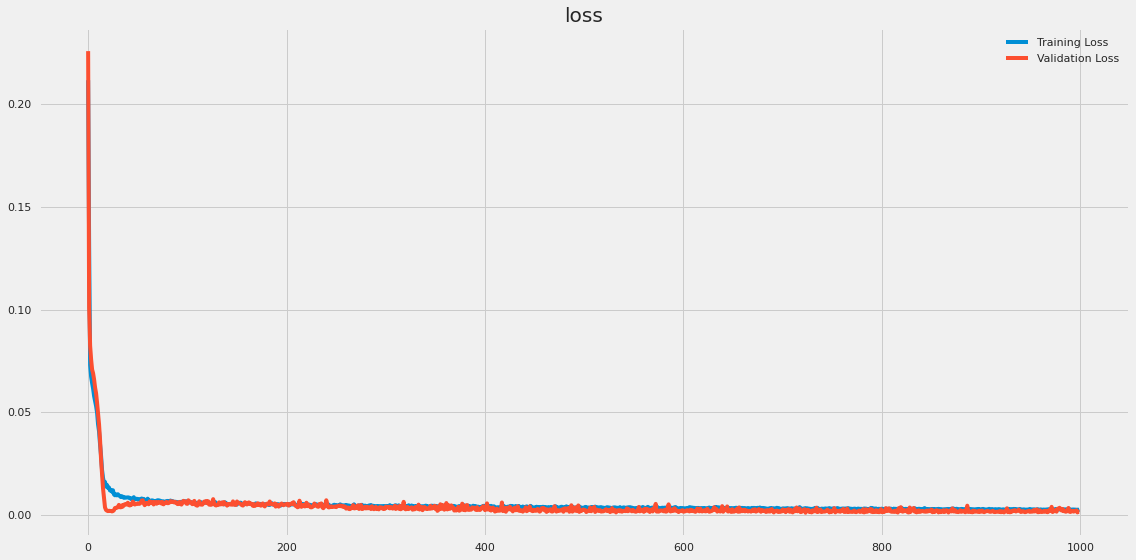

In [41]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title('loss')
plt.legend()
plt.show()

---

### Previsão

In [42]:
y_pred = model_lstm.predict(X_test)

In [43]:
# Rescale the data back to the original scale
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]

In [44]:
y_test[:10]

array([47.120003, 47.199997, 46.83    , 47.1     , 46.739998, 48.049995,
       48.86    , 48.85    , 49.879997, 49.97    ], dtype=float32)

In [45]:
len(y_test)

312

In [46]:
y_train[:10]

array([40.07    , 40.079998, 39.760002, 38.879997, 39.969997, 42.229996,
       42.47    , 43.370003, 43.71    , 43.730003], dtype=float32)

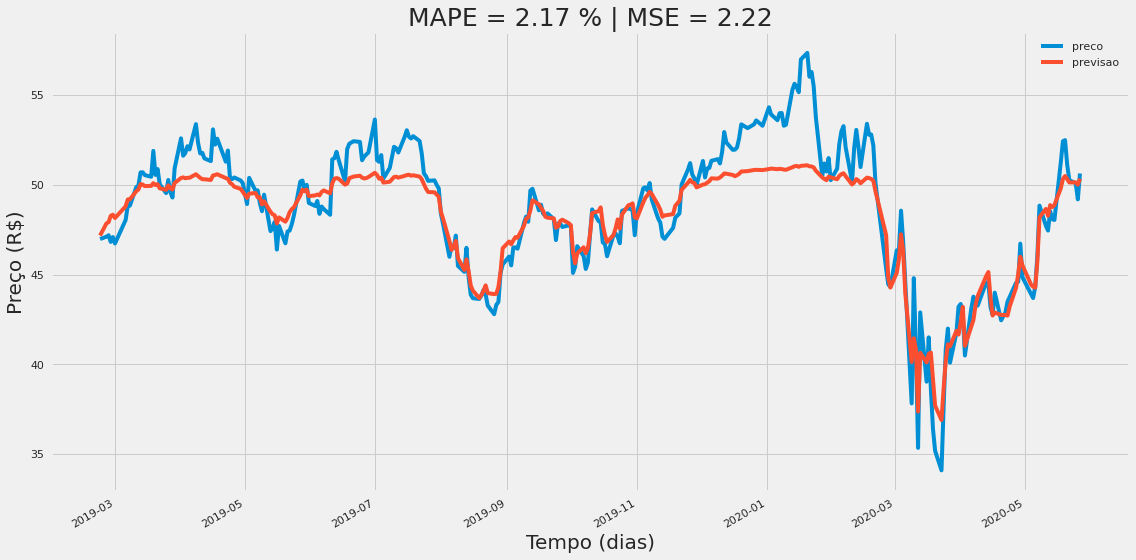

In [47]:
show_result_model(df_train=df_test['preco'][:312],
                  df_test=df_test['preco'][:312], 
                  y_forecast=y_pred[:312],
                  model_name='model_lstm')

---

## **Results**

In [48]:
dict_results

{'model_lstm': [2.1736652054111882, 2.223096210733722]}

---